In [9]:
from torchvision import transforms
from torch.utils import data
import numpy as np
import argparse
from transformers import AutoModel, AutoTokenizer, MambaForCausalLM
import torch
print(torch.__version__, torch.version.cuda)

from models_mamba import vim_base_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_middle_cls_token_div2
from mamba_lrp.model.vision_mamba import ModifiedVisionMamba

from huggingface_hub import hf_hub_download

2.8.0+cu128 12.8


## Dataset Loading

In [10]:
DATASET_ROOT = './CUB/DATASET/CUB_200_2011'
DATASET_VALIDATION_RANDOM_SEED = 123
BATCH_SIZE = 6
DATASET_WORK_NUMBER = 8
DATASET_SPLIT_RATIO = 0.9

In [11]:
from DatasetLoader.cub import CUB

trans_train = transforms.Compose([
    # A SCELTA NOSTRA AUGUMENTATION
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(30),
    
    # ATTENZIONE QUA NON DOVREBBE SERIVIRE IL RESIZE (?)
    # transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trans_test = transforms.Compose([
    # ATTENZIONE QUA NON DOVREBBE SERIVIRE IL RESIZE (?)
    transforms.Resize((224, 224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# create dataset
train_data = CUB(DATASET_ROOT, 'train', DATASET_SPLIT_RATIO, DATASET_VALIDATION_RANDOM_SEED, transform=trans_train)
valid_data = CUB(DATASET_ROOT, 'valid', DATASET_SPLIT_RATIO, DATASET_VALIDATION_RANDOM_SEED, transform=trans_test)
test_data = CUB(DATASET_ROOT, 'test', 0, 0, transform=trans_test)

print("Train: {}".format(len(train_data)))
print("Valid: {}".format(len(valid_data)))
print("Test: {}".format(len(test_data)))

Train: 5395
Valid: 599
Test: 5794


In [12]:
from matplotlib import pyplot as plt

def imshow(image, label, ax=None, normalize=True):
    """show single along with label on an ax"""
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(label)

    return ax


def show_samples(images, labels, nrows=2, ncols=3, title=None, normalize=True):
    """ show multiple samples

    args:
        nrows (int, optional): number of row
        ncols (int, optional): number of column
        title (str, optional): title.
        normalize (bool, optional): whether the images are normalized
    """
    fig, axes = plt.subplots(nrows, ncols, facecolor='#ffffff', dpi=100)

    # .flat: to map samples to multi-dimensional axes
    for (ax, image, label) in zip(axes.flat, images, labels):
        ax = imshow(image, label, ax, normalize)

    fig.suptitle(title)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.85, hspace=0.3)
    plt.show()
    

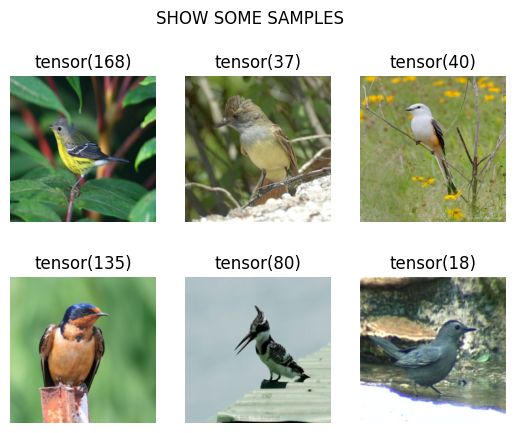

In [13]:
# show samples
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
images, labels = next(iter(train_loader))
show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME SAMPLES')

In [14]:
# create dataloader
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=DATASET_WORK_NUMBER)
valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=DATASET_WORK_NUMBER)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=DATASET_WORK_NUMBER)

# Model creation (work in progress)

#### parameters that were removed from previous versions of Mamba-ssm (and default values):
- bimamba_type (='v2' in VisionMamba, =False in Mamba-ssm)
- if_divide_out (=False)
- init_layer_scale (=None)

In [17]:
from huggingface_hub import list_repo_files
from einops import repeat
files = list_repo_files("hustvl/Vim-base-midclstok")
print(files)

['.gitattributes', 'README.md', 'vim_b_midclstok_81p9acc.pth']


In [ ]:
model = vim_base_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_middle_cls_token_div2(pretrained=False)

checkpoint_path = hf_hub_download(repo_id="hustvl/Vim-base-midclstok", filename="vim_b_midclstok_81p9acc.pth")

torch.serialization.add_safe_globals([argparse.Namespace])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
d_model = 16
expand = 2
d_inner = int(expand * d_model)

A_b = repeat(
    torch.arange(1, d_model + 1, dtype=torch.float32, device=device),
    "n -> d n",
    d=d_inner,
).contiguous()
A_b_log = torch.log(A_b)  # Keep A_b_log in fp32
model.A_b_log = torch.nn.Parameter(A_b_log)
model.A_b_log._no_weight_decay = True


# Load the model's weights

checkpoint = torch.load(checkpoint_path)
status = model.load_state_dict(checkpoint['model'], strict=False)

assert len(status.missing_keys) == 0


print(device)
model.to(device)
model.eval()


modified_model = ModifiedVisionMamba(model, zero_bias=True)
modified_model.eval()

#pretrained_embeddings = model.embeddings

RuntimeError: Error(s) in loading state_dict for VisionMamba:
	Missing key(s) in state_dict: "A_b_log". 
	Unexpected key(s) in state_dict: "layers.0.mixer.A_b_log", "layers.0.mixer.D_b", "layers.0.mixer.conv1d_b.weight", "layers.0.mixer.conv1d_b.bias", "layers.0.mixer.x_proj_b.weight", "layers.0.mixer.dt_proj_b.weight", "layers.0.mixer.dt_proj_b.bias", "layers.1.mixer.A_b_log", "layers.1.mixer.D_b", "layers.1.mixer.conv1d_b.weight", "layers.1.mixer.conv1d_b.bias", "layers.1.mixer.x_proj_b.weight", "layers.1.mixer.dt_proj_b.weight", "layers.1.mixer.dt_proj_b.bias", "layers.2.mixer.A_b_log", "layers.2.mixer.D_b", "layers.2.mixer.conv1d_b.weight", "layers.2.mixer.conv1d_b.bias", "layers.2.mixer.x_proj_b.weight", "layers.2.mixer.dt_proj_b.weight", "layers.2.mixer.dt_proj_b.bias", "layers.3.mixer.A_b_log", "layers.3.mixer.D_b", "layers.3.mixer.conv1d_b.weight", "layers.3.mixer.conv1d_b.bias", "layers.3.mixer.x_proj_b.weight", "layers.3.mixer.dt_proj_b.weight", "layers.3.mixer.dt_proj_b.bias", "layers.4.mixer.A_b_log", "layers.4.mixer.D_b", "layers.4.mixer.conv1d_b.weight", "layers.4.mixer.conv1d_b.bias", "layers.4.mixer.x_proj_b.weight", "layers.4.mixer.dt_proj_b.weight", "layers.4.mixer.dt_proj_b.bias", "layers.5.mixer.A_b_log", "layers.5.mixer.D_b", "layers.5.mixer.conv1d_b.weight", "layers.5.mixer.conv1d_b.bias", "layers.5.mixer.x_proj_b.weight", "layers.5.mixer.dt_proj_b.weight", "layers.5.mixer.dt_proj_b.bias", "layers.6.mixer.A_b_log", "layers.6.mixer.D_b", "layers.6.mixer.conv1d_b.weight", "layers.6.mixer.conv1d_b.bias", "layers.6.mixer.x_proj_b.weight", "layers.6.mixer.dt_proj_b.weight", "layers.6.mixer.dt_proj_b.bias", "layers.7.mixer.A_b_log", "layers.7.mixer.D_b", "layers.7.mixer.conv1d_b.weight", "layers.7.mixer.conv1d_b.bias", "layers.7.mixer.x_proj_b.weight", "layers.7.mixer.dt_proj_b.weight", "layers.7.mixer.dt_proj_b.bias", "layers.8.mixer.A_b_log", "layers.8.mixer.D_b", "layers.8.mixer.conv1d_b.weight", "layers.8.mixer.conv1d_b.bias", "layers.8.mixer.x_proj_b.weight", "layers.8.mixer.dt_proj_b.weight", "layers.8.mixer.dt_proj_b.bias", "layers.9.mixer.A_b_log", "layers.9.mixer.D_b", "layers.9.mixer.conv1d_b.weight", "layers.9.mixer.conv1d_b.bias", "layers.9.mixer.x_proj_b.weight", "layers.9.mixer.dt_proj_b.weight", "layers.9.mixer.dt_proj_b.bias", "layers.10.mixer.A_b_log", "layers.10.mixer.D_b", "layers.10.mixer.conv1d_b.weight", "layers.10.mixer.conv1d_b.bias", "layers.10.mixer.x_proj_b.weight", "layers.10.mixer.dt_proj_b.weight", "layers.10.mixer.dt_proj_b.bias", "layers.11.mixer.A_b_log", "layers.11.mixer.D_b", "layers.11.mixer.conv1d_b.weight", "layers.11.mixer.conv1d_b.bias", "layers.11.mixer.x_proj_b.weight", "layers.11.mixer.dt_proj_b.weight", "layers.11.mixer.dt_proj_b.bias", "layers.12.mixer.A_b_log", "layers.12.mixer.D_b", "layers.12.mixer.conv1d_b.weight", "layers.12.mixer.conv1d_b.bias", "layers.12.mixer.x_proj_b.weight", "layers.12.mixer.dt_proj_b.weight", "layers.12.mixer.dt_proj_b.bias", "layers.13.mixer.A_b_log", "layers.13.mixer.D_b", "layers.13.mixer.conv1d_b.weight", "layers.13.mixer.conv1d_b.bias", "layers.13.mixer.x_proj_b.weight", "layers.13.mixer.dt_proj_b.weight", "layers.13.mixer.dt_proj_b.bias", "layers.14.mixer.A_b_log", "layers.14.mixer.D_b", "layers.14.mixer.conv1d_b.weight", "layers.14.mixer.conv1d_b.bias", "layers.14.mixer.x_proj_b.weight", "layers.14.mixer.dt_proj_b.weight", "layers.14.mixer.dt_proj_b.bias", "layers.15.mixer.A_b_log", "layers.15.mixer.D_b", "layers.15.mixer.conv1d_b.weight", "layers.15.mixer.conv1d_b.bias", "layers.15.mixer.x_proj_b.weight", "layers.15.mixer.dt_proj_b.weight", "layers.15.mixer.dt_proj_b.bias", "layers.16.mixer.A_b_log", "layers.16.mixer.D_b", "layers.16.mixer.conv1d_b.weight", "layers.16.mixer.conv1d_b.bias", "layers.16.mixer.x_proj_b.weight", "layers.16.mixer.dt_proj_b.weight", "layers.16.mixer.dt_proj_b.bias", "layers.17.mixer.A_b_log", "layers.17.mixer.D_b", "layers.17.mixer.conv1d_b.weight", "layers.17.mixer.conv1d_b.bias", "layers.17.mixer.x_proj_b.weight", "layers.17.mixer.dt_proj_b.weight", "layers.17.mixer.dt_proj_b.bias", "layers.18.mixer.A_b_log", "layers.18.mixer.D_b", "layers.18.mixer.conv1d_b.weight", "layers.18.mixer.conv1d_b.bias", "layers.18.mixer.x_proj_b.weight", "layers.18.mixer.dt_proj_b.weight", "layers.18.mixer.dt_proj_b.bias", "layers.19.mixer.A_b_log", "layers.19.mixer.D_b", "layers.19.mixer.conv1d_b.weight", "layers.19.mixer.conv1d_b.bias", "layers.19.mixer.x_proj_b.weight", "layers.19.mixer.dt_proj_b.weight", "layers.19.mixer.dt_proj_b.bias", "layers.20.mixer.A_b_log", "layers.20.mixer.D_b", "layers.20.mixer.conv1d_b.weight", "layers.20.mixer.conv1d_b.bias", "layers.20.mixer.x_proj_b.weight", "layers.20.mixer.dt_proj_b.weight", "layers.20.mixer.dt_proj_b.bias", "layers.21.mixer.A_b_log", "layers.21.mixer.D_b", "layers.21.mixer.conv1d_b.weight", "layers.21.mixer.conv1d_b.bias", "layers.21.mixer.x_proj_b.weight", "layers.21.mixer.dt_proj_b.weight", "layers.21.mixer.dt_proj_b.bias", "layers.22.mixer.A_b_log", "layers.22.mixer.D_b", "layers.22.mixer.conv1d_b.weight", "layers.22.mixer.conv1d_b.bias", "layers.22.mixer.x_proj_b.weight", "layers.22.mixer.dt_proj_b.weight", "layers.22.mixer.dt_proj_b.bias", "layers.23.mixer.A_b_log", "layers.23.mixer.D_b", "layers.23.mixer.conv1d_b.weight", "layers.23.mixer.conv1d_b.bias", "layers.23.mixer.x_proj_b.weight", "layers.23.mixer.dt_proj_b.weight", "layers.23.mixer.dt_proj_b.bias". 

In [ ]:
from mamba_lrp.lrp.utils import vision_relevance_propagation

In [ ]:
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# get patch embeddings (Tensor), shape: (B, num_patches, embed_dim)
embeddings = modified_model.patch_embed(images)
#embeddings = model.patch_embed(images)

R, prediction, logits = vision_relevance_propagation(
    model = modified_model,
    embeddings = embeddings,
    targets = labels,
    n_classes = 200
)

AttributeError: 'ModifiedMamba' object has no attribute 'A_b_log'